In [1]:
import numpy as np
import gym
import random
import copy
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
class Actor(nn.Module):
    def __init__(self, scaling, state_size, hidden_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * scaling

In [3]:
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
class DDPG_Agent():
    def __init__(self, scaling, render, buffer_size, batch_size, gamma, tau, noise,
                state_size, hidden_size, action_size, actor_lr, critic_lr):
        
        self.scaling = scaling
        self.render = render
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.noise = noise
        
        self.state_size = state_size
        self.hidden_size = hidden_size
        self.action_size = action_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        
        self.actor = Actor(scaling, state_size, hidden_size, action_size)
        self.critic = Critic(state_size, hidden_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        
        self.state_memory = []
        self.next_state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.terminal_memory = []
        self.memory_counter = 0
        
    def train(self):
        state = env.reset()
        ep_reward = 0
        num_step = 0
        terminal = False
        
        while not terminal:
            
            if self.render:
                env.render()
                
            tensor_state = torch.from_numpy(state).float()            
            action = self.actor(tensor_state)
            action = torch.add(action, torch.from_numpy(np.random.normal(0, self.noise, self.action_size)))
            action = action.detach().numpy()
            next_state, reward, terminal, _ = env.step(action)
            ep_reward += reward

            if self.memory_counter < self.buffer_size: 
                self.state_memory.append(state)
                self.next_state_memory.append(next_state)
                self.action_memory.append(action)
                self.reward_memory.append(reward)
                self.terminal_memory.append(1 - terminal) # terminal = 1 if true so 0 if terminal            
            else:     
                index = self.memory_counter % self.buffer_size
                self.state_memory[index] = state
                self.next_state_memory[index] = next_state
                self.action_memory[index] = action
                self.reward_memory[index] = reward
                self.terminal_memory[index] = 1 - terminal
            self.memory_counter += 1 
                
            # If more items in memory list than batch size, sample items from each memory list
            if self.memory_counter >= self.batch_size: 
                batch = random.sample(range(len(self.state_memory)), self.batch_size) 
                states = []
                next_states = []
                actions = []
                rewards = []
                terminals = []
                
                for item in batch:
                    states.append(self.state_memory[item])
                    next_states.append(self.next_state_memory[item])
                    actions.append(self.action_memory[item])
                    rewards.append(self.reward_memory[item])
                    terminals.append(self.terminal_memory[item])
                
                # Reformat sample lists 
                states = np.array(states)
                next_states = np.array(next_states)
                actions = np.array(actions)
                states = torch.tensor(states)
                next_states = torch.tensor(next_states)
                actions = torch.tensor(actions)
                states = states.to(torch.float32) 
                actions = actions.to(torch.float32) 
                next_states = next_states.to(torch.float32) 
                
                # Gradient descent on critic prep
                target_actions = self.target_actor(next_states)
                next_Qtargets = self.target_critic(next_states, target_actions)
                Qtargets = []
                for i in range(self.batch_size):
                    Qtargets.append(rewards[i] + self.gamma * next_Qtargets[i] * terminals[i]) # If next state terminal, will be 0
                Qtargets = torch.tensor(Qtargets)
                Qtargets = Qtargets.view(self.batch_size, 1)
                
                # Gradient descent on critic
                Qexpected = self.critic(states, actions)
                critic_loss = nn.MSELoss()(Qexpected, Qtargets)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                # Gradient ascent on actor
                actions_predicted = self.actor(states)
                actor_loss = -self.critic(states, actions_predicted)
                actor_loss = torch.mean(actor_loss)
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # Update target networks
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic.parameters(), self.critic.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))                    

                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_actor.parameters(), self.actor.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))   
                
            state = next_state
            num_step += 1
            
        if self.render:
            env.close()
            
        return ep_reward
    
    def test(self):
        
        scores = []
        
        for i in range(100):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = torch.add(action, torch.from_numpy(np.random.normal(0, self.noise, self.action_size)))
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state
                
            print('Episode reward:', ep_reward)
            scores.append(ep_reward)
            
        print('SCORES DURING TESTING')
        x = [i for i in range(len(scores))]
        plt.plot(x, scores)
        plt.ylabel('SCORE')       
        plt.xlabel('EPISODES')
        plt.show()

    def visualise(self):
        for i in range(5):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                env.render()
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = torch.add(action, torch.from_numpy(np.random.normal(0, self.noise, self.action_size)))
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state

            print('Episode reward:', ep_reward)
            env.close()
            

Episode: 1/5 Score: -94.396 	 Average over last 50 episodes: -94.396
Episode: 2/5 Score: -96.274 	 Average over last 50 episodes: -95.335
Episode: 3/5 Score: -108.267 	 Average over last 50 episodes: -99.646
Episode: 4/5 Score: -118.422 	 Average over last 50 episodes: -104.340
Episode: 5/5 Score: -115.619 	 Average over last 50 episodes: -106.596
*************************************************************
Agent 1 complete	Average score of agent: -106.60
*************************************************************
SCORES DURING TRAINING


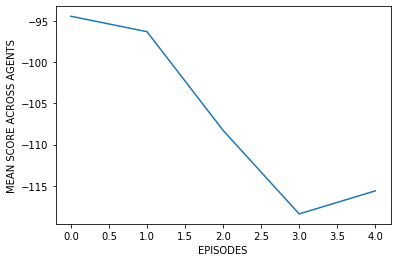

In [5]:
environment = 'BipedalWalker-v3' # Change environment name here
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
elif environment == 'LunarLanderContinuous-v2' or 'BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1

agents = 1
episodes = 2000
all_scores = []

for i in range(1, agents + 1):
    
    agent = DDPG_Agent(scaling = scaling, render = False, buffer_size = 1000000, batch_size = 100, gamma = 0.99, tau = 0.001, noise = 0.05,
                state_size = env.observation_space.shape[0], hidden_size = 300, action_size = env.action_space.shape[0], actor_lr = 0.0001, critic_lr = 0.001)
    agent_scores = []
    
    for j in range(1, episodes + 1):
        
        ep_reward = agent.train()
        agent_scores.append(ep_reward)
        if j % 1 == 0:
            print('Episode: {}/{} Score: {:.3f} \t Average over last 100 episodes: {:.3f}'.format(j, episodes, ep_reward, np.mean(agent_scores[-100:]))) 
    
    print('*************************************************************')
    print('Agent {} complete\tAverage score of agent: {:.2f}'.format(i, np.mean(agent_scores))) 
    print('*************************************************************')
    all_scores.append(agent_scores)

all_scores = np.array(all_scores)
mean_score = all_scores.mean(0)
x = [i for i in range(len(mean_score))]
print('SCORES DURING TRAINING')
plt.plot(x, mean_score)
plt.ylabel('MEAN SCORE ACROSS AGENTS')       
plt.xlabel('EPISODES')              
plt.show()

Episode reward: -113.96251482477551
Episode reward: -114.58999291085547
Episode reward: -113.9533820625044
Episode reward: -114.64156560229756
Episode reward: -114.34804406003634
Episode reward: -113.45156702456356
Episode reward: -114.17853219785745
Episode reward: -114.18452436315388
Episode reward: -113.93402514123294
Episode reward: -113.78126018952369
Episode reward: -113.96830828013078
Episode reward: -113.88957208781889
Episode reward: -113.61086763978169
Episode reward: -114.4588288882274
Episode reward: -113.96788914651863
Episode reward: -114.25965075679204
Episode reward: -114.15428696489401
Episode reward: -114.03351336778815
Episode reward: -114.12506749727392
Episode reward: -113.77594235891895
Episode reward: -113.8835807742397
Episode reward: -113.1259756218888
Episode reward: -113.88807296394666
Episode reward: -114.08126644034233
Episode reward: -114.03167707735862
Episode reward: -114.19698119360598
Episode reward: -114.20682055907038
Episode reward: -114.10101451746

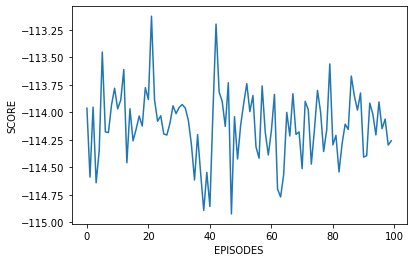

In [6]:
agent.test()

In [7]:
agent.visualise()

2022-05-02 16:16:34.933 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f7256fe0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:34.934 python[7428:241250] Warning: Expected min height of view: (<NSButton: 0x7fe2fa6092c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:34.936 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2fa609ce0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:34.937 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2fa60b1c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -113.98343047759184


2022-05-02 16:16:35.670 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f8d4cdb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:35.671 python[7428:241250] Warning: Expected min height of view: (<NSButton: 0x7fe2f8d70b30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:35.673 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f8d70de0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:35.675 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f8d71b60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -113.91623578986783


2022-05-02 16:16:36.349 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f937eb70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:36.350 python[7428:241250] Warning: Expected min height of view: (<NSButton: 0x7fe2f8d51f60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:36.352 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f8d526f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:36.354 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f61f7240>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -113.90727502310193


2022-05-02 16:16:37.005 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f892a910>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:37.005 python[7428:241250] Warning: Expected min height of view: (<NSButton: 0x7fe2f8935a00>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:37.008 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f8936190>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:37.010 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f8936f10>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -114.77356582976225


2022-05-02 16:16:37.718 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f9378c70>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:37.718 python[7428:241250] Warning: Expected min height of view: (<NSButton: 0x7fe2f8d78090>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:37.720 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f9db85c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-02 16:16:37.722 python[7428:241250] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fe2f9db3c90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -113.94353893995394
